<a href="https://colab.research.google.com/github/thien137/DiffuserCamLab/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.8 MB/s eta 0:00:00


In [ ]:
import pickle
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio
import scipy.io
from PIL import Image, ImageOps
from functools import partial
from torchvision import transforms
from torchmetrics import TotalVariation

In [ ]:
dtype = torch.float32
device = "cpu"
#if torch.cuda.is_available():
#    device = "cuda:0"
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [ ]:
# Output Gif
def exportGIF(im, sample_name, data_dir="./Images/", name="output.gif"):
  # "ReLU"
  rec = torch.maximum(im, torch.zeros(im.shape).to(device=device)).detach().cpu()
  # Normalize to [0,255] for imagio
  rec /= np.max(rec.numpy(), axis=(1,2))[..., None, None]
  rec *= 255
  imageio.mimsave(f"{data_dir}/{sample_name}/{name}", rec, loop=100)

In [ ]:
# Image Loading
def load_data(sample_name, data_dir="./Images"):
    # Constants
    PSF_BIAS = 102
    IMAGE_BIAS = 100

    # raw
    image_file = f"{data_dir}/{sample_name}/raw.png"
    raw = transforms.ToTensor()(Image.open(image_file)).to(device=device, dtype=dtype)

    # psf
    impulse_mat_file_name = f"{data_dir}/{sample_name}/psf.mat"
    impulse_var_name = "psf"
    #pre_psf = transforms.ToTensor()(Image.open(image_file)).to(device=device, dtype=dtype)
    pre_psf = transforms.ToTensor()(np.array(scipy.io.loadmat(impulse_mat_file_name)[impulse_var_name])).to(device=device, dtype=dtype)

    # get shape
    Z, M, N = pre_psf.shape

    # get padding (2M, 2N)
    padding = (N // 2, N // 2, M // 2, M // 2)

    # process images
    raw -= IMAGE_BIAS
    raw /= torch.max(raw)
    raw = torch.maximum(raw, torch.zeros(raw.shape).to(device=device, dtype=dtype))
    raw = F.pad(raw, padding, "constant")

    psf = torch.zeros((Z, M*2, N*2)).to(device=device, dtype=dtype)
    for i in range(len(psf)):
        psf[i] = F.pad(pre_psf[i], padding, "constant")
    psf -= PSF_BIAS
    psf = torch.maximum(psf, torch.zeros(psf.shape).to(device=device, dtype=dtype))

    return raw, psf

In [ ]:
raw, psf = load_data("example", "drive/MyDrive/DiffuserCam/Images/")

In [ ]:
np.vstack(map(np.ravel, np.mgrid[0:256:44j, 0:256:540j, 0:256:640j])).T

<ipython-input-8-e7450c2f3d1a>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.vstack(map(np.ravel, np.mgrid[0:256:44j, 0:256:540j, 0:256:640j])).T


array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.40062598],
       [  0.        ,   0.        ,   0.80125196],
       ...,
       [256.        , 256.        , 255.19874804],
       [256.        , 256.        , 255.59937402],
       [256.        , 256.        , 256.        ]])

In [ ]:
def to_tensor(arr):
  return torch.tensor(arr).to(device=device, dtype=dtype)

In [ ]:
# Rotation Algorithms
def rotateGridSample(im, u, theta):
  # Create Rotation Matrix with Translation
  u_x, u_y, u_z = u # Rotate on z-axis by 180 degrees
  R = [[np.cos(theta)+u_x**2*(1-np.cos(theta)), u_x*u_y*(1-np.cos(theta))-u_z*np.sin(theta), u_x*u_z*(1-np.cos(theta))+u_y*np.sin(theta)],
        [u_y*u_x*(1-np.cos(theta))+u_z*np.sin(theta), np.cos(theta)+u_y**2*(1-np.cos(theta)), u_y*u_z*(1-np.cos(theta))-u_x*np.sin(theta)],
        [u_z*u_x*(1-np.cos(theta))-u_y*np.sin(theta), u_z*u_y*(1-np.cos(theta))+u_x*np.sin(theta), np.cos(theta)+u_z**2*(1-np.cos(theta))]]
  t = [0, 0, 0]

  R_t = np.eye(4, 4)
  R_t[:3,:3] = R
  R_t[:3,3] = t
  R_t = to_tensor(R_t)

  # Rotate a 256, 256, 256
  # Reshape and interpolate to 44, 540, 640
  center_shift = to_tensor([128, 128, 128, 0])

  # Rotate 256x256x256
  coords = np.vstack(map(np.ravel, np.mgrid[0:255:44j,0:255:540j,0:255:640j])).T
  coords = np.hstack((coords, np.ones((coords.shape[0], 1))))
  coords = to_tensor(coords)
  coords -= center_shift

  rotated_coords = coords @ R_t
  rotated_coords += center_shift
  rotated_coords = torch.round(rotated_coords).to(int)

  # Send to 44x540x640
  mask = torch.all(rotated_coords >= to_tensor([0, 0, 0, 0]), axis=1) \
          & torch.all(rotated_coords <= to_tensor([255, 255, 255, 1]), axis=1)
  rotated_coords = rotated_coords[mask]

  normal_coords = np.vstack(map(np.ravel, np.mgrid[0:44,0:540,0:640])).T
  normal_coords = normal_coords[mask]
  normal_coords = to_tensor(normal_coords).to(int)

  reconstruction = np.zeros((44, 540, 640))
  reconstruction[normal_coords[:,0], normal_coords[:,1], normal_coords[:,2]] = im[rotated_coords[:,0], rotated_coords[:,1], rotated_coords[:,2]]

  return reconstruction

In [ ]:
# FFT Algorithms
def conv2d(x, psf):
    x_f = torch.fft.fft2(x)
    psf_f = torch.fft.fft2(psf)
    conv = torch.fft.ifft2(x_f * psf_f)
    conv = torch.fft.ifftshift(conv).real
    return conv

def fft_forward(x, psf):
    Z, M, N = x.shape
    forward = torch.zeros(1, M*2, N*2).to(device=device, dtype=dtype)
    for i in range(Z):
        forward += conv2d(x[i], psf[i])
    return forward

class Convolution_FFT(nn.Module):
    def __init__(self, noise, u, theta):
        super().__init__()

        # Flatten Image Size
        self.image_width = 256
        self.image_height = 256
        self.depth = 256
        self.weight = nn.Parameter(noise * torch.rand(self.depth, self.image_height, self.image_width)
                                   .to(device=device, dtype=dtype))
        self.u = u
        self.theta = theta

    def forward(self, input):
        forward = torch.zeros(1, self.image_height, self.image_width).to(device=device, dtype=dtype)
        rotated_weights = rotateGridSample(self.weight, self.u, self.theta)
        for i in range(self.depth):
            forward += conv2d(rotated_weights[i], input[i])
        return forward

In [ ]:
# Training Algorithm
def model_train(config, raw, psf, model=None, epochs=200):
    print("Begin Training...")
    if not model:
        Z, M, N = psf.shape
        model = Convolution_FFT(config["noise"], config["u"], config["theta"])
        model = model.to(device=device)

    mse_fn = nn.MSELoss().to(device=device)
    tv_fn = TotalVariation().to(device=device)
    def criterion(forward):
        l1_regularization = config["l1"] * torch.norm(model.weight, 1)
        tv_regularization = config["tv"] * tv_fn(model.weight.unsqueeze(0))
        mse_loss = mse_fn(forward, raw)
        return mse_loss + l1_regularization + tv_regularization
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    fig, ax = plt.subplots()

    running_loss = np.array([])
    for epoch in range(epochs):
        # model.train()
        optimizer.zero_grad()

        forward = model(psf)
        loss = criterion(forward)
        loss.backward()
        optimizer.step()

        model.weight.data = torch.maximum(model.weight, torch.zeros(model.weight.shape).to(device=device, dtype=dtype))

        # Log Statistics
        log_loss = np.log(loss.item())
        running_loss = np.append(running_loss, log_loss)

        # Print Statistics
        if epoch % 10 == 0:
            print('Epoch %d, loss = %.16f' % (epoch, log_loss))

    plt.plot(np.arange(0, len(running_loss)), running_loss)
    plt.show()
    return model

In [ ]:
model_config = {
    "l1": 1e-5,
    "tv": 1e-5,
    "noise": 1e-9,
    "lr": 1e-4,
    "u": torch.tensor([1, 0, 0]),
    "theta": 0
}

Begin Training...


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `TotalVariation` from `torchmetrics` was deprecated and will be removed in 2.0. Import `TotalVariation` from `torchmetrics.image` instead.
  _future_warning(
<ipython-input-81-2e2b00c0c541>:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  coords = np.vstack(map(np.ravel, np.mgrid[0:255:44j,0:255:540j,0:255:640j])).T
<ipython-input-81-2e2b00c0c541>:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  normal_coords = np.vstack(map(np.ravel, np.mgrid[0:44,0:540,0:640])).T


RuntimeError: ignored

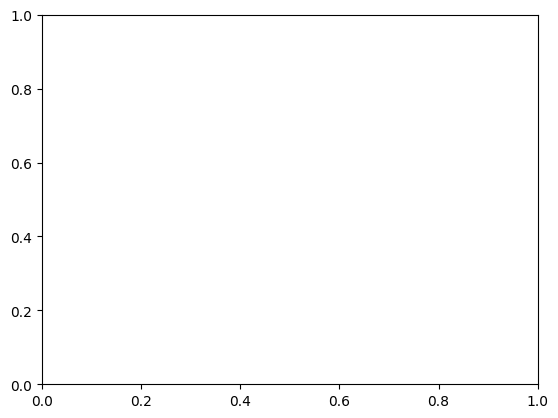

In [ ]:
model_fft = model_train(model_config, raw, psf, epochs=500)

In [ ]:
exportGIF(model_fft.weight, "patrick", "drive/MyDrive/DiffuserCam/Images", "(0, 1, 0)_45.gif")